
# Libor Market MonteCarlo Model

## Pricing Zero Coupon Bond Option

Assume that a Libor Market Model where all forward rates are driven by a single Brownian motion. Use the model to price an option on a Zero Coupon Bond. The options has 1 year maturity, with strikes at 0.90. The underlyings, the zero-coupon bond has a maturity of 4 years, or 3 years from the time the option mature. Use 1,000 simulation and 256 daily steps. The data contains the discount factors and the caplets' forward volatilities. 


The plan is as follows:

From the Caplets' forward Volatilities we extract the volatility of forward rates (with the formula at pages 721-722 in the book).

Once the volatilities are available, we set up the forward dynamics to price the two derivatives with maturity at $T = 1$ year.

The pricing is a Monte Carlo simulation where the forward rates are discretized at time steps, $dt$, of 1 day. 

The simulations start at year 1, when the options mature. We simulate $12$ forward rates, which are those necessary to value the simulated values of the $3$-$year$ ZCB and $3$-$year$ IR swap. 

The algo we use in the simulation is also provided in the book at page 723, and we report it below.

$$ f^{s}_n(t+dt,T_{i},T_{i+1}) = f^{s}_n(t,T_{i},T_{i+1}) e^{m^{s}_{i+1}(t)dt+S(T_{i+1}-t)\sqrt{dt}\epsilon^{s}_t}  $$

where:
$$ m^{s}_{i+1}(t) = \sum_{j=i^-}^{i} \frac{0.25f^{s}_n(t,T_{j},T_{j+1})S(T_{i+1}-t)S(T_{j+1}-t)}{f^{s}_n(t,T_{j},T_{j+1})} - \frac{1}{2}S(T_{i+1}-t)^{2}$$

- $\epsilon$ : is ~$N(0,1)$
- $s$ : is the simulation number
- $i^{-}$ : is the option maturity, which is year 1 in our case
- $i$ : are the times thereafter...

also note that all forward rates share the same $\epsilon$ ~$N(0,1)$

The options' values are calculated as follows:

$$ V^{ZCBOption} = Z(0,1)\frac{1}{10000}\sum_{i=1}^{10000}\left(Z^{s}(T_0,T_M)-0.9,0)\right) = 0.5889 $$

$$ V^{Swaption} = Z(0,1)\frac{1}{10000}\sum_{i=1}^{10000}\left(V^{swap,s}(T_0,T_M),0)\right) = 0.6107 $$


$$ V^{swap,s} = \sum_{i=1}^{3}\frac{0.035}{2}Z^{s}(T_0,T_i) + Z^{s}(T_0,T_M) - 1$$  
$$ i = .5, 1, 1.5, 2, 2.5, 3 $$

$$ Z^{s}(T_0,T_M) = \frac{1}{1+r_n(T_0,T_{0.25})} *\frac{1}{1+f_n(T_0,T_{0.25},T_{0.5})}*...*\frac{1}{1+f_n(T_0,T_{M-0.25},T_M)} $$

where:
- $T_M$ : is 4 years
- $T_0$ : is 1 year
- $Z^{s}(T_0,T_i)$ : is the future discount factor from the period $T_0$ and $T_i$
- $Z^{s}(T_0,T_M)$ : is the future discount factor from the period $T_0$ and $T_M$
- $Z(0,1)$ : is the current discount factor with maturity of $1$  $year$
- $r$ and $f$ : are the simulated rates from time $T_0$ when the options mature 

In [ ]:
import pandas as pd
import numpy as np
import numpy.random as npr
from scipy.interpolate import splrep, splev
import matplotlib.pyplot as plt
%matplotlib inline

Let's read our data set:

In [98]:
ForwardRates = pd.read_csv ('LLM_1.csv', index_col=False)
print (ForwardRates.head(2))
print (ForwardRates.tail(2))
size = len(ForwardRates)

   Maturity        DF  FwdRate_qc  CapletsForwardVols
0      0.25  0.994580    0.021800             0.21156
1      0.50  0.988508    0.024568             0.22810
    Maturity        DF  FwdRate_qc  CapletsForwardVols
15      4.00  0.868212    0.045274              0.2682
16      4.25  0.858245    0.046454              0.2589


In [99]:
print (ForwardRates.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17 entries, 0 to 16
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Maturity            17 non-null     float64
 1   DF                  17 non-null     float64
 2   FwdRate_qc          17 non-null     float64
 3   CapletsForwardVols  17 non-null     float64
dtypes: float64(4)
memory usage: 676.0 bytes
None


In [100]:
# We need functions to price 
# 1 . Swaption receiver
# 2 . ZCB and to calculate
# 3 . continously compounded forward and spot rates, from DFs
def ZCB(FwdRates):    
    # we assume rates are on a 3-month basis
    size = len(np.zeros(len(FwdRates)))

    # Prerare the forward discount factors    
    FDFs = 1/(1+FwdRates*0.25)
    
    # Prepare the spot discount factors
    DFs = np.cumprod(FDFs)
    
    # and return the Value of a ZCB
    return DFs[-1]

def CC_Spot_and_Forward(FwdRates):    

    size = len(np.zeros(len(FwdRates)))
    
    # Prerare the forward discount factors    
    FDFs  = 1/(1+FwdRates*0.25)
    ccfwd = -np.log(FDFs)/0.25
    
    # Prepare the spot discount factors
    DFs = np.cumprod(FDFs)
    j   = 0.25
    ccspot = np.zeros(size)
    for i, val in enumerate(DFs): 
        ccspot[i] = -np.log(val)/j
        j +=0.25
        
    return ccspot, ccfwd 

We also need a function to interpolate between points on the volatility of the forward rates. 
The volatility vector $S$ above, where the simulation algo is provided, contains data $S(T_{j+1}-t)$ at points in time = {0.25, 0.50, ...}

In the algo above, as the simulations move ahead in time $t$, we need values between those points. For example after the first time step $dt$, $t$ has increased by $dt$, so we need volatility values at the points in time = {0.25 - dt, 0.50 - dt, ...} 

In [101]:
def f_cubic(x, x1, y1):
    ret = splrep(x1, y1)
    return splev(x, ret)

From the Caplets' vols we extract the volatility of forward rates.

In [102]:
CapletsForwardVols  =  np.asarray(ForwardRates.CapletsForwardVols)
size = len(CapletsForwardVols)

In [103]:
Vol_Fwd_Rate_S     = np.zeros(size)
Calc_S             = np.zeros(size)
Vol_Fwd_Rate_S[0]  = CapletsForwardVols[0]
Calc_S[0]          = CapletsForwardVols[0]**2*0.25
for i in range(1, size):
    x = CapletsForwardVols[i]**2 * ForwardRates.Maturity[i]
    y = np.sum(Calc_S)
    if(x>y):
        Vol_Fwd_Rate_S[i] = 2*np.sqrt(x-y)
    Calc_S[i] = Vol_Fwd_Rate_S[i]**2*0.25 

In [104]:
Vol_Fwd_Rate_S # are the S[] in the algo above

array([0.21156   , 0.24351917, 0.3027016 , 0.36136126, 0.40676204,
       0.42238968, 0.3754561 , 0.23526445, 0.10101094, 0.05529837,
       0.17359654, 0.27908415, 0.28428903, 0.24460043, 0.16843518,
       0.        , 0.        ])

plot them against the orignal inputs

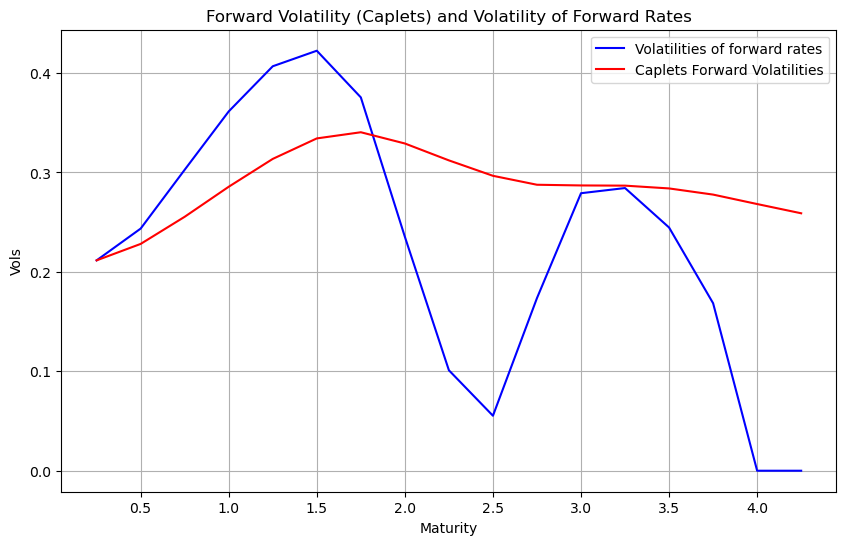

In [105]:
plt.figure(figsize=(10,6))
plt.plot(ForwardRates.Maturity[0:size], Vol_Fwd_Rate_S, lw=1.5, color='blue', label ='Volatilities of forward rates')
plt.plot(ForwardRates.Maturity[0:size], CapletsForwardVols, lw=1.5,   color='red', label ='Caplets Forward Volatilities')
plt.legend()
plt.xlabel('Maturity')  
plt.ylabel('Vols')
plt.grid(True)
plt.title("Forward Volatility (Caplets) and Volatility of Forward Rates");
plt.show()

The rates are simulated daily, over a period of 256 trading days. The model always assumes that the options mature in one year.

In [106]:
OptionMaturity  = 1  

In [107]:
#daily simulations 
SimulationPaths = 256

#The maturity of the underlying fixed income security. 
Maturity        = 4    

#Number of forward rates that we are simulating. S
#Simulate quarterly compounded forward rates, with four forward rates per year. 
No_of_fwd_rates = (Maturity - OptionMaturity) * 4 

In [108]:
No_of_Simulations = 1000 # simulations

In [109]:
#We will price option on a ZCB and 
ZCB_Strike      = 0.9

#Swaption_Strike = 0.035

#Vectors will containg the Payoff of the option
ZCB_Value         = np.zeros(No_of_Simulations)

In [110]:
#Generate matrix of uncorrelated gaussian distributed numbers (with mean = 0 and sd = 1)
npr.seed(1200)
StandardNormal = npr.standard_normal((SimulationPaths,No_of_Simulations))
StandardNormal.shape

(256, 1000)

In [111]:
#The current Forward rates
#First entry is the same as the current spot rate. The rates are compounded on a quarterly basis, all with tenors of 0.25 months.
#We will ONLY need to simulate the forward rates starting from the period after the option matures. 
#To calcuate the option payoff, we need to calculate the Discounting Factors from after the option expires.

FRqc    = np.asarray(ForwardRates.FwdRate_qc)

In [112]:
# Create a lower Diagonal Matrix
s           = (No_of_fwd_rates,No_of_fwd_rates)
DriftMatrix = np.ones(s) 
DriftMatrix = np.tril(DriftMatrix, k=0)

### Simulation

In [113]:
# In case you do NOT need all simulated forward rates uncomment this
oldFRqcMatrix = np.zeros((No_of_fwd_rates,SimulationPaths +1 ,No_of_Simulations))

for j in range(0, No_of_Simulations):
    
#The option expires at the 4th quarter. Simulate the forward rates starting from the period following the time the option expires
    oldFRqc              = FRqc[4:-1] 
    
    # In case you do NOT need all simulated forward rates uncomment this
    oldFRqcMatrix[:,0,j] = oldFRqc
    
    for i in range(0,int(SimulationPaths)):
        
        dt                   = i/float(SimulationPaths)
                
        DriftMatrix_FwdRates = DriftMatrix * 0.25*oldFRqc/(1+oldFRqc*0.25)
        VolFwdRate_toUpdate  = f_cubic(ForwardRates.Maturity - dt,ForwardRates.Maturity, Vol_Fwd_Rate_S)
        
        # outer product of the Fwd Rate volatilities         
        temp = np.multiply.outer(VolFwdRate_toUpdate[4:-1], VolFwdRate_toUpdate[4:-1])        
        
        DriftMatrix_FwdRates_Vol = DriftMatrix_FwdRates*temp
        mu      = (DriftMatrix_FwdRates_Vol.sum(axis=1)-0.5*VolFwdRate_toUpdate[4:-1]**2)*1/float(SimulationPaths)
        mu      = np.asarray(mu)
        
        vol     = VolFwdRate_toUpdate[4:-1]*StandardNormal[i,j]
        vol     = np.asarray(vol)
        
        muDrift = mu + vol*np.sqrt(1/float(SimulationPaths))
         
        NewFRqc = oldFRqc*np.exp(muDrift)
        oldFRqc = NewFRqc
        
        # In case you do NOT want to see all simulated forward rates uncomment this
        oldFRqcMatrix[:,i+1,j] = NewFRqc

            
    # Valuing the ZCB with the simulated forward rates
    ZCB_Value[j]  = ZCB(oldFRqc)    

In [114]:
# Prepare the forward and spot rates from the last simulation at the time when the options expire.
spot, forward = CC_Spot_and_Forward(oldFRqc)

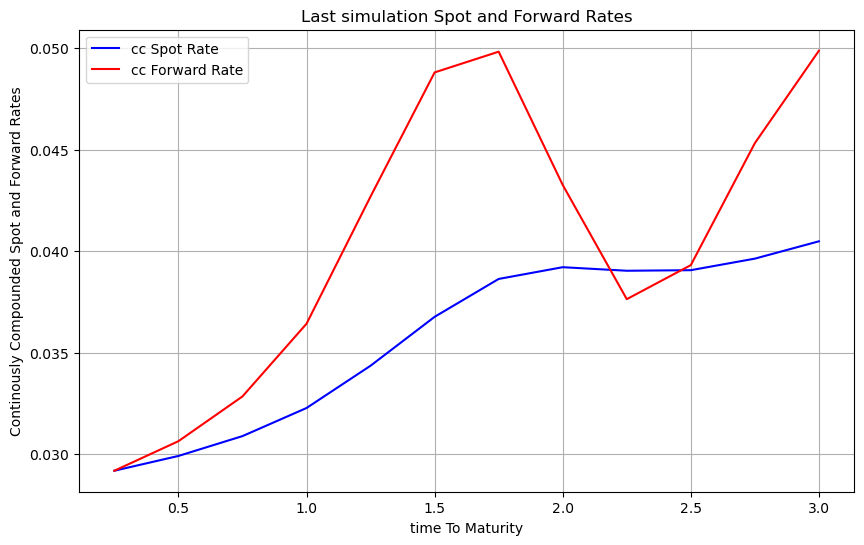

In [115]:
plt.figure(figsize=(10,6))
plt.plot(ForwardRates.Maturity[0:12], spot, lw=1.5, color='blue', label ='cc Spot Rate')
plt.plot(ForwardRates.Maturity[0:12], forward, lw=1.5,   color='red', label ='cc Forward Rate')
plt.legend()
plt.xlabel('time To Maturity')  
plt.ylabel('Continously Compounded Spot and Forward Rates')
plt.grid(True)
plt.title("Last simulation Spot and Forward Rates");
plt.show()

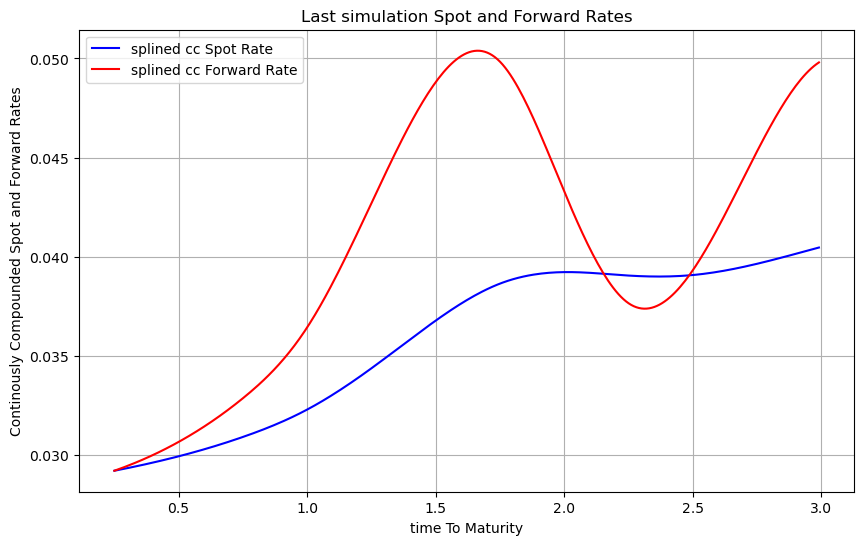

In [116]:
Maturities = np.arange (0.25, 3, 0.01)

plt.figure(figsize=(10,6))
plt.plot(Maturities, f_cubic(Maturities,ForwardRates.Maturity[0:12], spot), lw=1.5, color='blue', label ='splined cc Spot Rate')
plt.plot(Maturities, f_cubic(Maturities,ForwardRates.Maturity[0:12], forward), lw=1.5,   color='red', label ='splined cc Forward Rate')
plt.legend()
plt.xlabel('time To Maturity')  
plt.ylabel('Continously Compounded Spot and Forward Rates')
plt.grid(True)
plt.title("Last simulation Spot and Forward Rates");
plt.show()

In [117]:
print (np.round(np.mean(np.maximum(ZCB_Value   - ZCB_Strike,0)) * ForwardRates.DF[3]*100,5))
#print (np.round(np.mean(np.maximum(Swap_Value,0))               * ForwardRates.DF[3]*100,5))

0.57052


In [118]:
#At time T= 1yr, the average value of the ZCB maturing at T = 4yr is very close to the Forward Price implied in the current Discount Factor

print (np.round(np.mean(ZCB_Value),4))
print (np.round(ForwardRates.DF[15] / ForwardRates.DF[3],4))

0.8907
0.8906


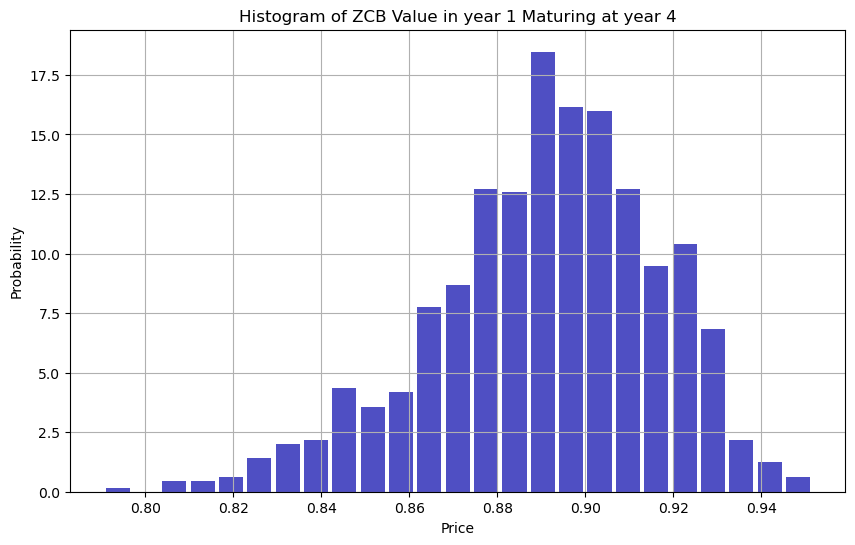

[0.001 0.    0.003 0.003 0.004 0.009 0.013 0.014 0.028 0.023 0.027 0.05
 0.056 0.082 0.081 0.119 0.104 0.103 0.082 0.061 0.067 0.044 0.014 0.008
 0.004]
1.0000000000000002


In [119]:
#Distribution of the value of the ZCB at time T = 1, which matures at T = 4yr

plt.figure(figsize=(10,6))
n, bins, patches = plt.hist(x=ZCB_Value, density = True, bins='auto', color='#0504aa',alpha=0.7, rwidth=0.85)
plt.grid(True)
plt.xlabel('Price')
plt.ylabel('Probability')
plt.title('Histogram of ZCB Value in year 1 Maturing at year 4')
plt.show()

n /= np.sum(n)
print(np.round(n,5))
print(np.sum(n))

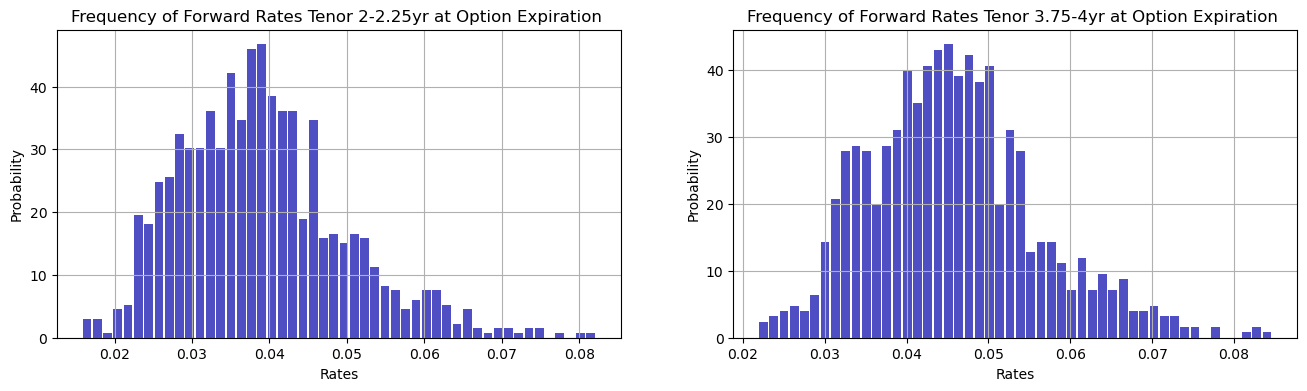

In [120]:
#Distribution of two of the 12 forward rates at time T = 1. Both are very lognormal!

plt.figure(figsize=(16,4))
plt.subplot(121)
n, bins, patches = plt.hist(x=oldFRqcMatrix[5,-1,:], density=True,bins=50, color='#0504aa',alpha=0.7, rwidth=0.85)
plt.grid(True)
plt.xlabel('Rates')
plt.ylabel('Probability')
plt.title("Frequency of Forward Rates Tenor 2-2.25yr at Option Expiration ")
plt.subplot(122)
n, bins, patches = plt.hist(x=oldFRqcMatrix[11,-1,:], density = True, bins=50, color='#0504aa',alpha=0.7, rwidth=0.85)
plt.grid(True)
plt.xlabel('Rates')
plt.ylabel('Probability')
plt.title("Frequency of Forward Rates Tenor 3.75-4yr at Option Expiration ")
plt.show()

In [121]:
import scipy
#Use Kolmogorov-Smirnov test to check lognormal distribution
print(scipy.stats.kstest(oldFRqcMatrix[5,-1,:], "lognorm", scipy.stats.lognorm.fit(oldFRqcMatrix[5,-1,:])))
print(scipy.stats.kstest(oldFRqcMatrix[11,-1,:], "lognorm", scipy.stats.lognorm.fit(oldFRqcMatrix[11,-1,:])))

KstestResult(statistic=0.022605112548078843, pvalue=0.6776879748528148, statistic_location=0.03709218921720082, statistic_sign=-1)
KstestResult(statistic=0.020816799295272692, pvalue=0.7708701357970875, statistic_location=0.053703253607898356, statistic_sign=1)


## Multifactor Libor Market Model

Data includes the volatility of forward rates, estimated by taking the standard deviation of the change in the log of forward rates as well as the principal components of the change in log forward rates.

The multifactor LMM generates a lower price. Although the volatility of forward rates is the same, the single factor, with a perfect correlation across all forward rates, implies higher volatility of the bond price, $Z(T_0,T_M)$, as all forward rates tend to move together. The multifactor LMM, where forward rates are not perfectly correlated across maturities, generates a lower volatility of the bond price and so calculates a lower price.

$$ f^{s}_n(t+dt,T_{i},T_{i+1}) = f^{s}_n(t,T_{i},T_{i+1}) e^{m^{s}_{i+1}(t)dt+\sum_{k=1}^{3}S_k(T_{i+1}-t)\sqrt{dt}\epsilon^{s}_{t,k}} $$

where:
$$ m^{s}_{i+1}(t) = \sum_{j=i^-}^{i} \frac{0.25f^{s}_n(t,T_{j},T_{j+1})\sum_{k=1}^{3} S_k(T_{i+1}-t)S_k(T_{j+1}-t)}{f^{s}_n(t,T_{j},T_{j+1})} -\sum_{k=1}^{3} \frac{1}{2}S_k(T_{i+1}-t)^{2}$$

- $\epsilon_{t,k}$ : are now three independent ~$N(0,1)$
- $s$ : is the simulation number
- $i^{-}$ : is the option maturity, which is year 1 in our case
- $i$ : are the times thereafter, and 
- $k$ : are the three principal component factors 

In [122]:
ForwardRates = pd.read_csv ('LLM_2.csv', index_col=False)
print (ForwardRates.head(2))
print (ForwardRates.tail(2))
size = len(ForwardRates)

   Maturity        DF  FwdRate_qc  FwdRateVol  FactorS1Vol  FactorS2Vol  \
0      0.25  0.993335    0.026839     0.41729      0.27915     -0.27035   
1      0.50  0.987306    0.024426     0.42793      0.35810     -0.21802   

   FactorS3Vol  
0      0.14192  
1      0.08038  
    Maturity        DF  FwdRate_qc  FwdRateVol  FactorS1Vol  FactorS2Vol  \
23      6.00  0.800106    0.049478     0.14557      0.10858      0.09092   
24      6.25  0.790226    0.050011     0.14381      0.10493      0.09159   

    FactorS3Vol  
23      0.02604  
24      0.02920  


In [123]:
print (ForwardRates.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Maturity     25 non-null     float64
 1   DF           25 non-null     float64
 2   FwdRate_qc   25 non-null     float64
 3   FwdRateVol   25 non-null     float64
 4   FactorS1Vol  25 non-null     float64
 5   FactorS2Vol  25 non-null     float64
 6   FactorS3Vol  25 non-null     float64
dtypes: float64(7)
memory usage: 1.5 KB
None


Volatility vectors of the forward rates:

In [124]:
# Vol_Fwd_Rate_S are the S[] in the algo above

Vol_Fwd_Rate_S  =  np.asarray(ForwardRates.FwdRateVol)
Vol_Factor_S1   =  np.asarray(ForwardRates.FactorS1Vol)
Vol_Factor_S2   =  np.asarray(ForwardRates.FactorS2Vol)
Vol_Factor_S3   =  np.asarray(ForwardRates.FactorS3Vol)

Vol_Fwd_Rate_S_Squared  =  Vol_Fwd_Rate_S**2
Vol_Factor_Sum_Squared  =  Vol_Factor_S1**2+Vol_Factor_S2**2+Vol_Factor_S3**2

3 PCA factors:

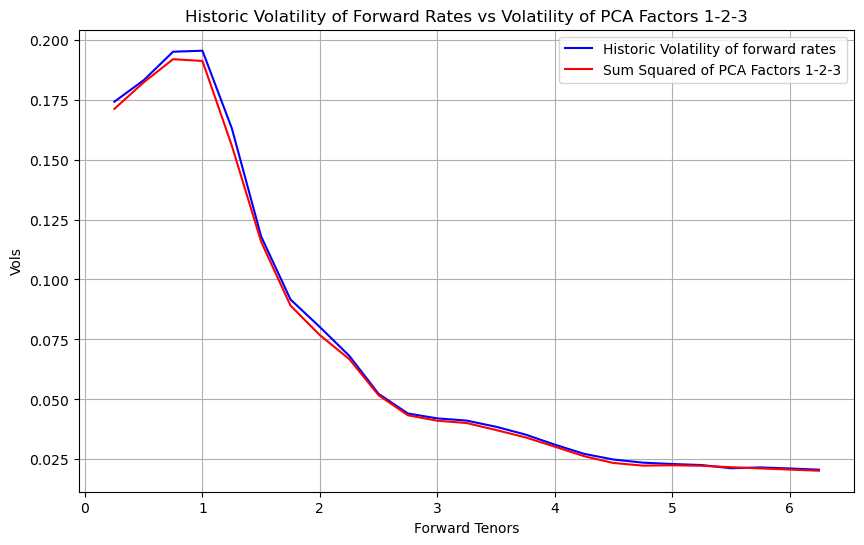

In [125]:
plt.figure(figsize=(10,6))
plt.plot(ForwardRates.Maturity[0:size], Vol_Fwd_Rate_S_Squared, lw=1.5, color='blue', label ='Historic Volatility of forward rates')
plt.plot(ForwardRates.Maturity[0:size], Vol_Factor_Sum_Squared, lw=1.5,   color='red', label ='Sum Squared of PCA Factors 1-2-3')
plt.legend()
plt.xlabel('Forward Tenors')  
plt.ylabel('Vols')
plt.grid(True)
plt.title("Historic Volatility of Forward Rates vs Volatility of PCA Factors 1-2-3");
plt.show()

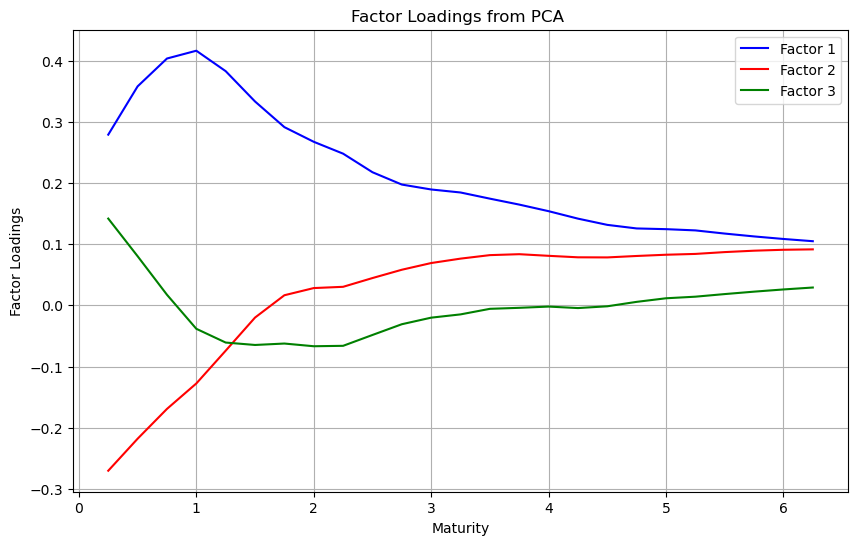

In [126]:
plt.figure(figsize=(10,6))
plt.plot(ForwardRates.Maturity[0:size], Vol_Factor_S1, lw=1.5, color='blue', label ='Factor 1')
plt.plot(ForwardRates.Maturity[0:size], Vol_Factor_S2, lw=1.5,   color='red', label ='Factor 2')
plt.plot(ForwardRates.Maturity[0:size], Vol_Factor_S3, lw=1.5,   color='green', label ='Factor 3')

plt.legend()
plt.xlabel('Maturity')  
plt.ylabel('Factor Loadings')
plt.grid(True)
plt.title("Factor Loadings from PCA ");
plt.show()

The rates are simulated monthy:

In [127]:
OptionMaturity  = 1
SimulationPaths = 12.0 #in months

In [128]:
#maturity of the underlying fixed income security. 
Maturity        = 6    

#number of forward rates simulated
No_of_fwd_rates = (Maturity - OptionMaturity) * 4 

No_of_Simulations = 1000 # simulations

In [129]:
#Payoff of the ZCB 
ZCB_Value         = np.zeros(No_of_Simulations)
ZCB_Value_with_Correlation = np.zeros(No_of_Simulations)

### Independent Forward Rates

In [130]:
#matrix of uncorrelated gaussian distributed numbers (with mean = 0 and sd = 1)
npr.seed(1500)
StandardNormal = npr.standard_normal((int(SimulationPaths),No_of_Simulations))
StandardNormal.shape

(12, 1000)

In [131]:
# current Forward rates
FRqc    = np.asarray(ForwardRates.FwdRate_qc)

In [132]:
# Create a lower Diagonal Matrix
s           = (No_of_fwd_rates,No_of_fwd_rates)
DriftMatrix = np.ones(s) 
DriftMatrix = np.tril(DriftMatrix, k=0)

In [133]:
for j in range(0, No_of_Simulations):
    '''
    The option expires at the 4th quarter. 
    We simulate the forward rates starting from the period following the time the option expires
    '''
    oldFRqc    = FRqc[4:-1]  
        
    for i in range(0,int(SimulationPaths)):
        dt                  = i/float(SimulationPaths)
                        
        DriftMatrix_FwdRates= DriftMatrix * 0.25*oldFRqc/(1+oldFRqc*0.25)
        VolFwdRate_toUpdate = f_cubic(ForwardRates.Maturity - dt,ForwardRates.Maturity, Vol_Fwd_Rate_S)

        # outer product of the Fwd Rate volatilities         
        temp = np.multiply.outer(VolFwdRate_toUpdate[4:-1], VolFwdRate_toUpdate[4:-1])        
        
        DriftMatrix_FwdRates_Vol = DriftMatrix_FwdRates*temp
        mu      = (DriftMatrix_FwdRates_Vol.sum(axis=1)-0.5*VolFwdRate_toUpdate[4:-1]**2)*1/float(SimulationPaths)
        mu      = np.asarray(mu)
        
        vol     = VolFwdRate_toUpdate[4:-1]*StandardNormal[i,j]
        vol     = np.asarray(vol)
    
        muDrift = mu + vol*np.sqrt(1/float(SimulationPaths))
                
        NewFRqc = oldFRqc*np.exp(muDrift)
        oldFRqc = NewFRqc
        
    
    # Valuing the ZCB with the simulated forward rates
    ZCB_Value[j]  = ZCB(oldFRqc)

In [134]:
# forward and spot rates from the last simulation at the time when the options expire.
spot, forward = CC_Spot_and_Forward(oldFRqc)

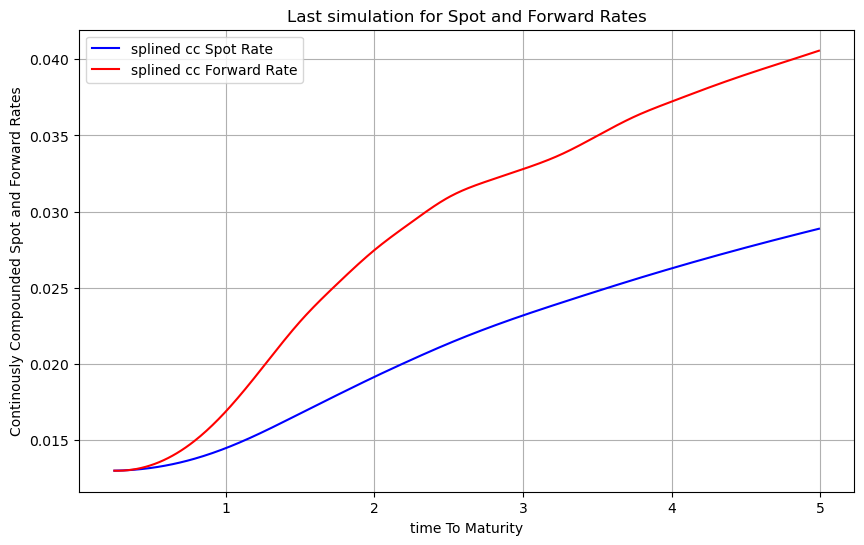

In [135]:
Maturities = np.arange (0.25, 5, 0.01)

plt.figure(figsize=(10,6))
plt.plot(Maturities, f_cubic(Maturities,ForwardRates.Maturity[0:20], spot), lw=1.5, color='blue', label ='splined cc Spot Rate')
plt.plot(Maturities, f_cubic(Maturities,ForwardRates.Maturity[0:20], forward), lw=1.5,   color='red', label ='splined cc Forward Rate')
plt.legend()
plt.xlabel('time To Maturity')  
plt.ylabel('Continously Compounded Spot and Forward Rates')
plt.grid(True)
plt.title("Last simulation for Spot and Forward Rates");
plt.show()

In [136]:
# at time T= 1yr, the average value of the ZCB is very close to  the Forward Price implied in the current Discount Factor
print (np.round(np.mean(ZCB_Value),5))
print (np.round(ForwardRates.DF[23] / ForwardRates.DF[3],4))

0.82155
0.8198


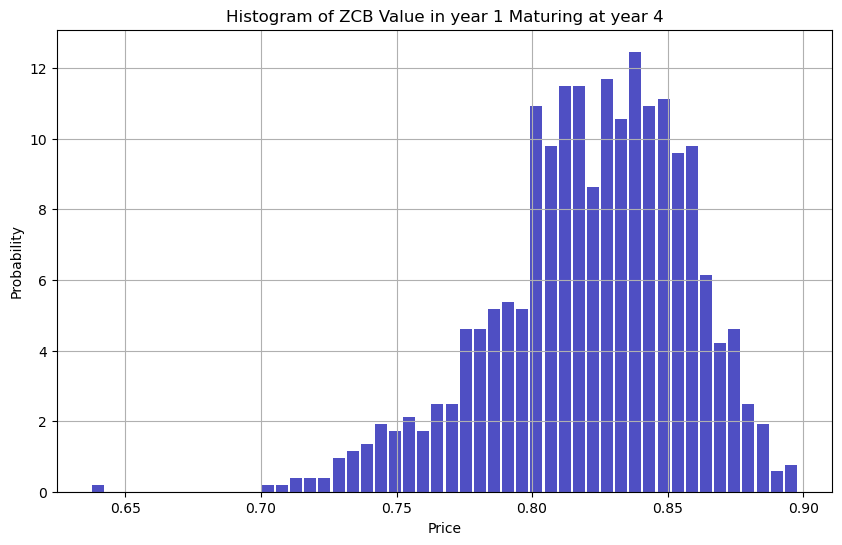

In [137]:
plt.figure(figsize=(10,6))
n, bins, patches = plt.hist(x=ZCB_Value, density = True, bins=50, color='#0504aa',alpha=0.7, rwidth=0.85)
plt.grid(True)
plt.xlabel('Price')
plt.ylabel('Probability')
plt.title('Histogram of ZCB Value in year 1 Maturing at year 4')
plt.show()

## Multifactor Forward Rates

In [138]:
# matrix of uncorrelated gaussian distributed numbers (with mean = 0 and sd = 1)  for the three PCA Factors
npr.seed(1500)
StandardNormal1 = npr.standard_normal((int(SimulationPaths),No_of_Simulations))
StandardNormal2 = npr.standard_normal((int(SimulationPaths),No_of_Simulations))
StandardNormal3 = npr.standard_normal((int(SimulationPaths),No_of_Simulations))
print(StandardNormal1.shape)

(12, 1000)


In [139]:
for j in range(0, No_of_Simulations):
   #The option expires at the 4th quarter. Simulate the forward rates starting from the period following the time the option expires    
    oldFRqcCorr = FRqc[4:-1] 
        
    for i in range(0,int(SimulationPaths)):
        dt                      = i/float(SimulationPaths)
        
        DriftMatrix_FwdRates    = DriftMatrix * 0.25*oldFRqcCorr/(1+oldFRqcCorr*0.25)               
        
        Vol_Factor_S1_toUpdate  = f_cubic(ForwardRates.Maturity - dt,ForwardRates.Maturity, Vol_Factor_S1)
        Vol_Factor_S2_toUpdate  = f_cubic(ForwardRates.Maturity - dt,ForwardRates.Maturity, Vol_Factor_S2)
        Vol_Factor_S3_toUpdate  = f_cubic(ForwardRates.Maturity - dt,ForwardRates.Maturity, Vol_Factor_S3)        
        
        size      = len(Vol_Factor_S1_toUpdate[4:-1])
        PSAComp   = np.vstack((Vol_Factor_S1_toUpdate[4:-1],Vol_Factor_S2_toUpdate[4:-1], Vol_Factor_S3_toUpdate[4:-1])) 
        s         = (size,size)
        PSAMatrix = np.zeros(s) 
        for ki in range(0, size):
            for kj in range(0, size):
                PSAMatrix[kj,ki] = np.dot(PSAComp[:,kj], PSAComp[:,ki])
        
        
        DriftMatrix_FwdRates_Vol = DriftMatrix_FwdRates*PSAMatrix
        v       = Vol_Factor_S1_toUpdate[4:-1]**2 + Vol_Factor_S2_toUpdate[4:-1]**2 + Vol_Factor_S3_toUpdate[4:-1]**2
        muCorr  = (DriftMatrix_FwdRates_Vol.sum(axis=1) - 0.5*v)*1/float(SimulationPaths)             
        muCorr  = np.asarray(muCorr)
        
        volCorr = Vol_Factor_S1_toUpdate[4:-1]*StandardNormal1[i,j] + \
                  Vol_Factor_S2_toUpdate[4:-1]*StandardNormal2[i,j] + \
                  Vol_Factor_S3_toUpdate[4:-1]*StandardNormal3[i,j]         

        volCorr     = np.asarray(volCorr)                
        muCorrDrift = muCorr + volCorr * np.sqrt(1/float(SimulationPaths))
        
        NewFRqcCorr = oldFRqcCorr  * np.exp(muCorrDrift)
        oldFRqcCorr = NewFRqcCorr
        
    # Valuing the ZCB with the simulated forward rates
    ZCB_Value_with_Correlation[j]  = ZCB(oldFRqcCorr)

In [140]:
# forward and spot rates from the last simulation at the time when the options expire.
spotCorr, forwardCorr = CC_Spot_and_Forward(oldFRqcCorr)

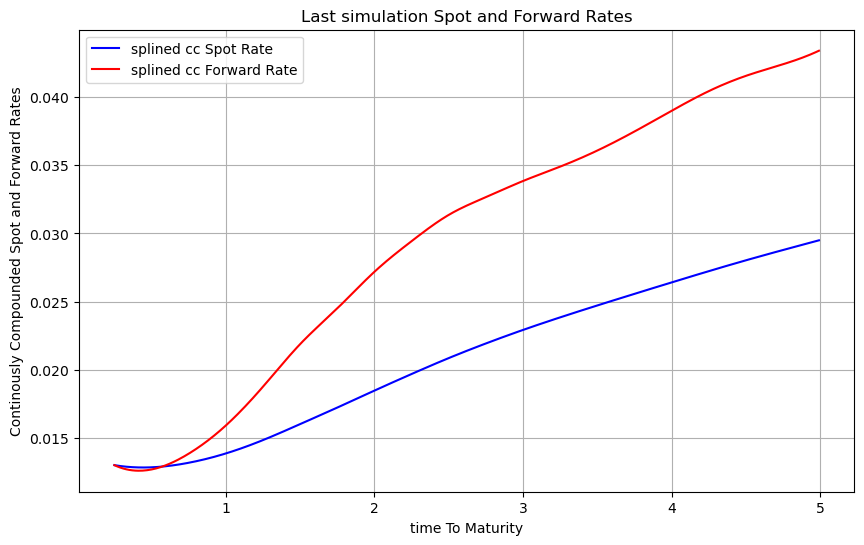

In [141]:
Maturities = np.arange (0.25, 5, 0.01)

plt.figure(figsize=(10,6))
plt.plot(Maturities, f_cubic(Maturities,ForwardRates.Maturity[0:20], spotCorr), lw=1.5, color='blue', label ='splined cc Spot Rate')
plt.plot(Maturities, f_cubic(Maturities,ForwardRates.Maturity[0:20], forwardCorr), lw=1.5,   color='red', label ='splined cc Forward Rate')
plt.legend()
plt.xlabel('time To Maturity')  
plt.ylabel('Continously Compounded Spot and Forward Rates')
plt.grid(True)
plt.title("Last simulation Spot and Forward Rates");
plt.show()

In [142]:
# at time T= 1yr, the average value of the ZCB is very close to  the Forward Price implied in the current Discount Factor

print (np.round(np.mean(ZCB_Value_with_Correlation),4))
print (np.round(ForwardRates.DF[23] / ForwardRates.DF[3],4))

0.8213
0.8198


Volatility of the bond price, $Z(T_0,T_M)$.

On the left below is the case with a single factor LMM vs the chart on the right with multifactor LMM. 

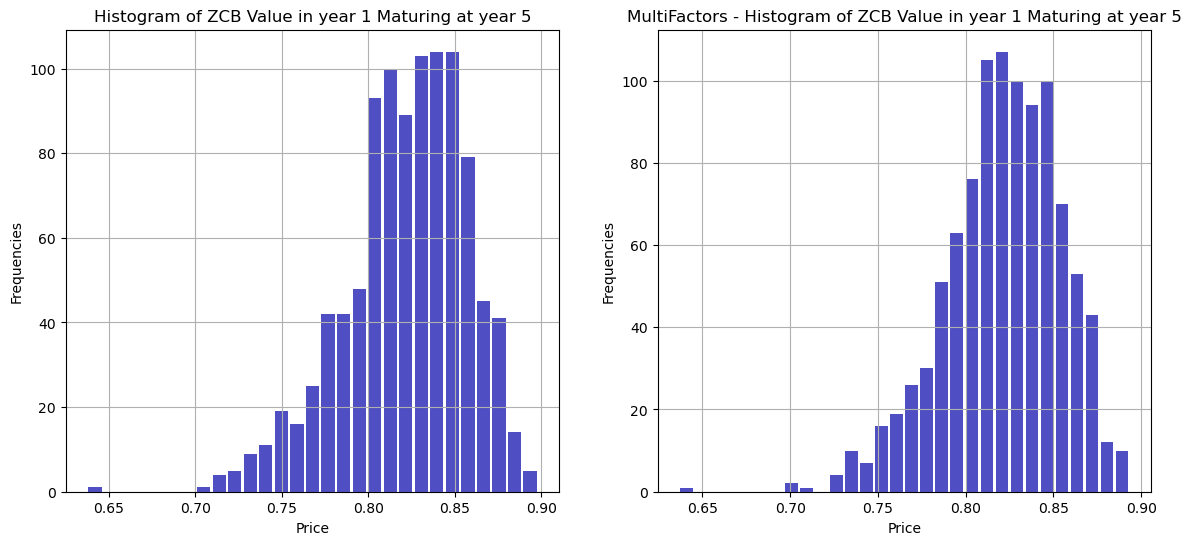

In [143]:
plt.figure(figsize=(14,6))

plt.subplot(1, 2, 1)
n, bins, patches = plt.hist(ZCB_Value, density = False, bins='auto', color='#0504aa',alpha=0.7, rwidth=0.85)
plt.grid(True)
plt.xlabel('Price')
#plt.ylim(0, 14)
plt.ylabel('Frequencies')
plt.title('Histogram of ZCB Value in year 1 Maturing at year 5')


plt.subplot(1, 2, 2)
n, bins, patches = plt.hist(x=ZCB_Value_with_Correlation, density = False, bins='auto', color='#0504aa',alpha=0.7, rwidth=0.85)
plt.grid(True)
plt.xlabel('Price')
#plt.ylim(0, 14)
plt.ylabel('Frequencies')
plt.title('MultiFactors - Histogram of ZCB Value in year 1 Maturing at year 5')

plt.show()